In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

plt.rcParams.update({
    "figure.dpi": 600,
    "figure.figsize": (6, 2.5),
    "font.size": 10,
    "mathtext.fontset": "stix"
})

In [2]:
def calculate_analytical_Vm_bn2s(params, freqs):
    """
    Calculates analytical soma Vm amplitude

    Args:
        params (dict): A dictionary containing the biophysical parameters.
        freqs (np.ndarray): An array of frequencies (in Hz) to calculate the PSD for.

    Returns:
        tuple: A tuple containing:
            - freqs (np.ndarray): The input frequency array.
            - V_m (np.ndarray): The absolute value of the calculated V_m for the ball-and-two-stick model.
    """
    # --- 1. Extract parameters and convert to SI units ---
    Rm = params['Rm']  # Specific membrane resistance (Ohm * m^2)
    Ri = params['Ri']  # Axial resistivity (Ohm * m)
    Cm = params['Cm']  # Specific membrane capacitance (F / m^2)
    d = params['d']    # Stick diameter (m)
    ds = params['ds']  # Soma diameter (m)
    l1 = params['l1']  # Length of stick 1 (m)
    l2 = params['l2']  # Length of stick 2 (m)
    s_in = params['s_in'] # PSD of white noise input current (A^2 / Hz)

    # --- 2. Calculate derived cable properties ---
    # Angular frequency
    omega = 2 * np.pi * freqs
    # Add a small epsilon to the first frequency to avoid division by zero if f=0
    omega[0] = omega[0] + 1e-9

    # Membrane time constant (s)
    tau_m = Rm * Cm

    # Length constant (m)
    # This is the standard definition from cable theory (e.g., Rall, 1959)
    lambda_ = np.sqrt((d * Rm) / (4 * Ri))

    # Electrotonic lengths (dimensionless)
    L1 = l1 / lambda_
    L2 = l2 / lambda_

    # Dimensionless frequency
    W = omega * tau_m

    # Complex frequency-dependent term q
    q = np.sqrt(1 + 1j * W)

    # --- 3. Calculate admittances (inverse of impedance) ---
    # Admittance of the soma (S)
    Ys = np.pi * ds**2 * (1/Rm) * q**2

    # Infinite-stick admittance (S)
    G_inf = np.pi * d**2 / (4 * Ri * lambda_)
    Y_inf = q * G_inf

    # Total input admittance seen by the soma (S)
    # This is the parallel sum of the soma and the two finite sticks.
    Y_in_total = Ys + Y_inf * (np.tanh(q * L1) + np.tanh(q * L2))

    # --- 4. Calculate the transfer function T_p(f) ---
    # Derived for the ball-and-two-stick model.
    # The numerator represents the difference in dipole moments from the two sticks.
    numerator = lambda_ * G_inf * (1/np.cosh(q * L2) - 1/np.cosh(q * L1))

    # The denominator is the total admittance
    denominator = Y_in_total

    T_p = numerator / denominator
    abs_T_p = np.abs(T_p)

    # Membrane potential from Transfer function
    V_m = 1e-3 * abs_T_p

    return freqs, V_m

In [3]:
def calculate_analytical_Vm_bn2s_with_sym(params, freqs):
    """
    Calculates analytical soma Vm amplitude, with the symmetry factor l2 = sym * l1

    Args:
        params (dict): A dictionary containing the biophysical parameters.
        freqs (np.ndarray): An array of frequencies (in Hz) to calculate the PSD for.

    Returns:
        tuple: A tuple containing:
            - freqs (np.ndarray): The input frequency array.
            - V_m (np.ndarray): The absolute value of the calculated V_m for the ball-and-two-stick model.
    """
    # --- 1. Extract parameters and convert to SI units ---
    Rm = params['Rm']  # Specific membrane resistance (Ohm * m^2)
    Ri = params['Ri']  # Axial resistivity (Ohm * m)
    Cm = params['Cm']  # Specific membrane capacitance (F / m^2)
    d = params['d']    # Stick diameter (m)
    ds = params['ds']  # Soma diameter (m)
    l1 = params['l1']  # Length of stick 1 (m)
    sym = params['sym']  # Symmetry factor determenting the length of stick 2
    s_in = params['s_in'] # PSD of white noise input current (A^2 / Hz)

    # --- 2. Calculate derived cable properties ---
    # Angular frequency
    omega = 2 * np.pi * freqs
    # Add a small epsilon to the first frequency to avoid division by zero if f=0
    omega[0] = omega[0] + 1e-9

    # Membrane time constant (s)
    tau_m = Rm * Cm

    # Length constant (m)
    # This is the standard definition from cable theory (e.g., Rall, 1959)
    lambda_ = np.sqrt((d * Rm) / (4 * Ri))

    # Electrotonic lengths (dimensionless)
    L1 = l1 / lambda_
    L2 = sym * L1

    # Dimensionless frequency
    W = omega * tau_m

    # Complex frequency-dependent term q
    q = np.sqrt(1 + 1j * W)

    # --- 3. Calculate admittances (inverse of impedance) ---
    # Admittance of the soma (S)
    Ys = np.pi * ds**2 * (1/Rm) * q**2

    # Infinite-stick admittance (S)
    G_inf = np.pi * d**2 / (4 * Ri * lambda_)
    Y_inf = q * G_inf

    # Total input admittance seen by the soma (S)
    # This is the parallel sum of the soma and the two finite sticks.
    Y_in_total = Ys + Y_inf * (np.tanh(q * L1) + np.tanh(q * L2))

    # --- 4. Calculate the transfer function T_p(f) ---
    # Derived for the ball-and-two-stick model.
    # The numerator represents the difference in dipole moments from the two sticks.
    numerator = lambda_ * G_inf * (1/np.cosh(q * L2) - 1/np.cosh(q * L1))

    # The denominator is the total admittance
    denominator = Y_in_total

    T_p = numerator / denominator
    abs_T_p = np.abs(T_p)

    # Membrane potential from Transfer function
    V_m = 1e-3 * abs_T_p

    return freqs, V_m

In [4]:
def mark_subplots(axes, letters='ABCDEFGHIJKLMNOPQRSTUVWXYZ', xpos=-0.12, ypos=1.15, fontsize = 10):

    if not type(axes) is list:
        axes = [axes]

    for idx, ax in enumerate(axes):
        ax.text(xpos, ypos, letters[idx].capitalize(),
                horizontalalignment='center',
                verticalalignment='center',
                fontweight='demibold',
                fontsize=fontsize,
                transform=ax.transAxes)

In [5]:
# Standard parameters
standard_neuron_parameters = {
    'Rm': 3.0,          # Ohm * m^2
    'Ri': 1.5,          # Ohm * m
    'Cm': 0.01,         # F / m^2
    'd': 2e-6,          # 2 um -> m
    'ds': 20e-6,        # 20 um -> m
    'l1': 0.67e-3,      # 0.67 mm -> m (Longer stick)
    'l2': 0.33e-3,      # 0.33 mm -> m (Shorter stick)V_m_vary_symmetry
    's_in': (1e-15)**2  # 1 fA^2/Hz -> A^2/Hz
}

standard_neuron_parameters_sym = {
    'Rm': 3.0,          # Ohm * m^2
    'Ri': 1.5,          # Ohm * m
    'Cm': 0.01,         # F / m^2
    'd': 2e-6,          # 2 um -> m
    'ds': 20e-6,        # 20 um -> m
    'l1': 0.67e-3,      # 0.67 mm -> m (Longer stick)
    'sym': 0.5,         # l2 = 0.5*l1 (Shorter stick)
    's_in': (1e-15)**2  # 1 fA^2/Hz -> A^2/Hz
}

In [6]:
# Vary total length fixed symmetry
lens = np.arange(100,1000,200)
frequencies = np.logspace(-1, 4, 1000)

V_m_vary_abs_len = {}

for l in lens:
    params_copy = standard_neuron_parameters_sym.copy()
    params_copy['l1'] = l * 1e-6

    tot_len = (params_copy['l1'] + (params_copy['sym']*params_copy['l1']))*10**6

    freqs, abs_V_m = calculate_analytical_Vm_bn2s_with_sym(params_copy, frequencies)

    V_m_vary_abs_len[tot_len] = {
        'freqs': freqs,
        'abs_V_m': abs_V_m
    }

    del freqs, abs_V_m

In [7]:
# Vary symmetry
syms = np.arange(0.1, 0.9, 0.2)

V_m_vary_symmetry = {}

for sym in syms:
    params_copy = standard_neuron_parameters_sym.copy()
    params_copy['sym'] = sym

    freqs, abs_V_m = calculate_analytical_Vm_bn2s_with_sym(params_copy, frequencies)

    V_m_vary_symmetry[sym] = {
        'freqs': freqs,
        'abs_V_m': abs_V_m
    }

    del freqs, abs_V_m

In [8]:
# Vary stick diameter
diams = np.arange(2,20,4)

V_m_vary_dend_diam = {}

for d_d in diams:
    params_copy = standard_neuron_parameters.copy()
    params_copy['d'] = d_d * 1e-6

    freqs, abs_V_m = calculate_analytical_Vm_bn2s(params_copy, frequencies)

    V_m_vary_dend_diam[d_d] = {
        'freqs': freqs,
        'abs_V_m': abs_V_m
    }

    del freqs, abs_V_m

In [9]:
# Vary soma diam
diams = np.arange(10,30,4)

V_m_vary_soma_diam = {}

for d_s in diams:
    params_copy = standard_neuron_parameters.copy()
    params_copy['ds'] = d_s * 1e-6

    freqs, abs_V_m = calculate_analytical_Vm_bn2s(params_copy, frequencies)

    V_m_vary_soma_diam[d_s] = {
        'freqs': freqs,
        'abs_V_m': abs_V_m
    }

    del freqs, abs_V_m

/var/folders/bg/0phzw_wj05x5crg_p858d9b80000gn/T/ipykernel_62082/1884427418.py:73: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 1, 0.97]) # rect is used to make space for suptitle


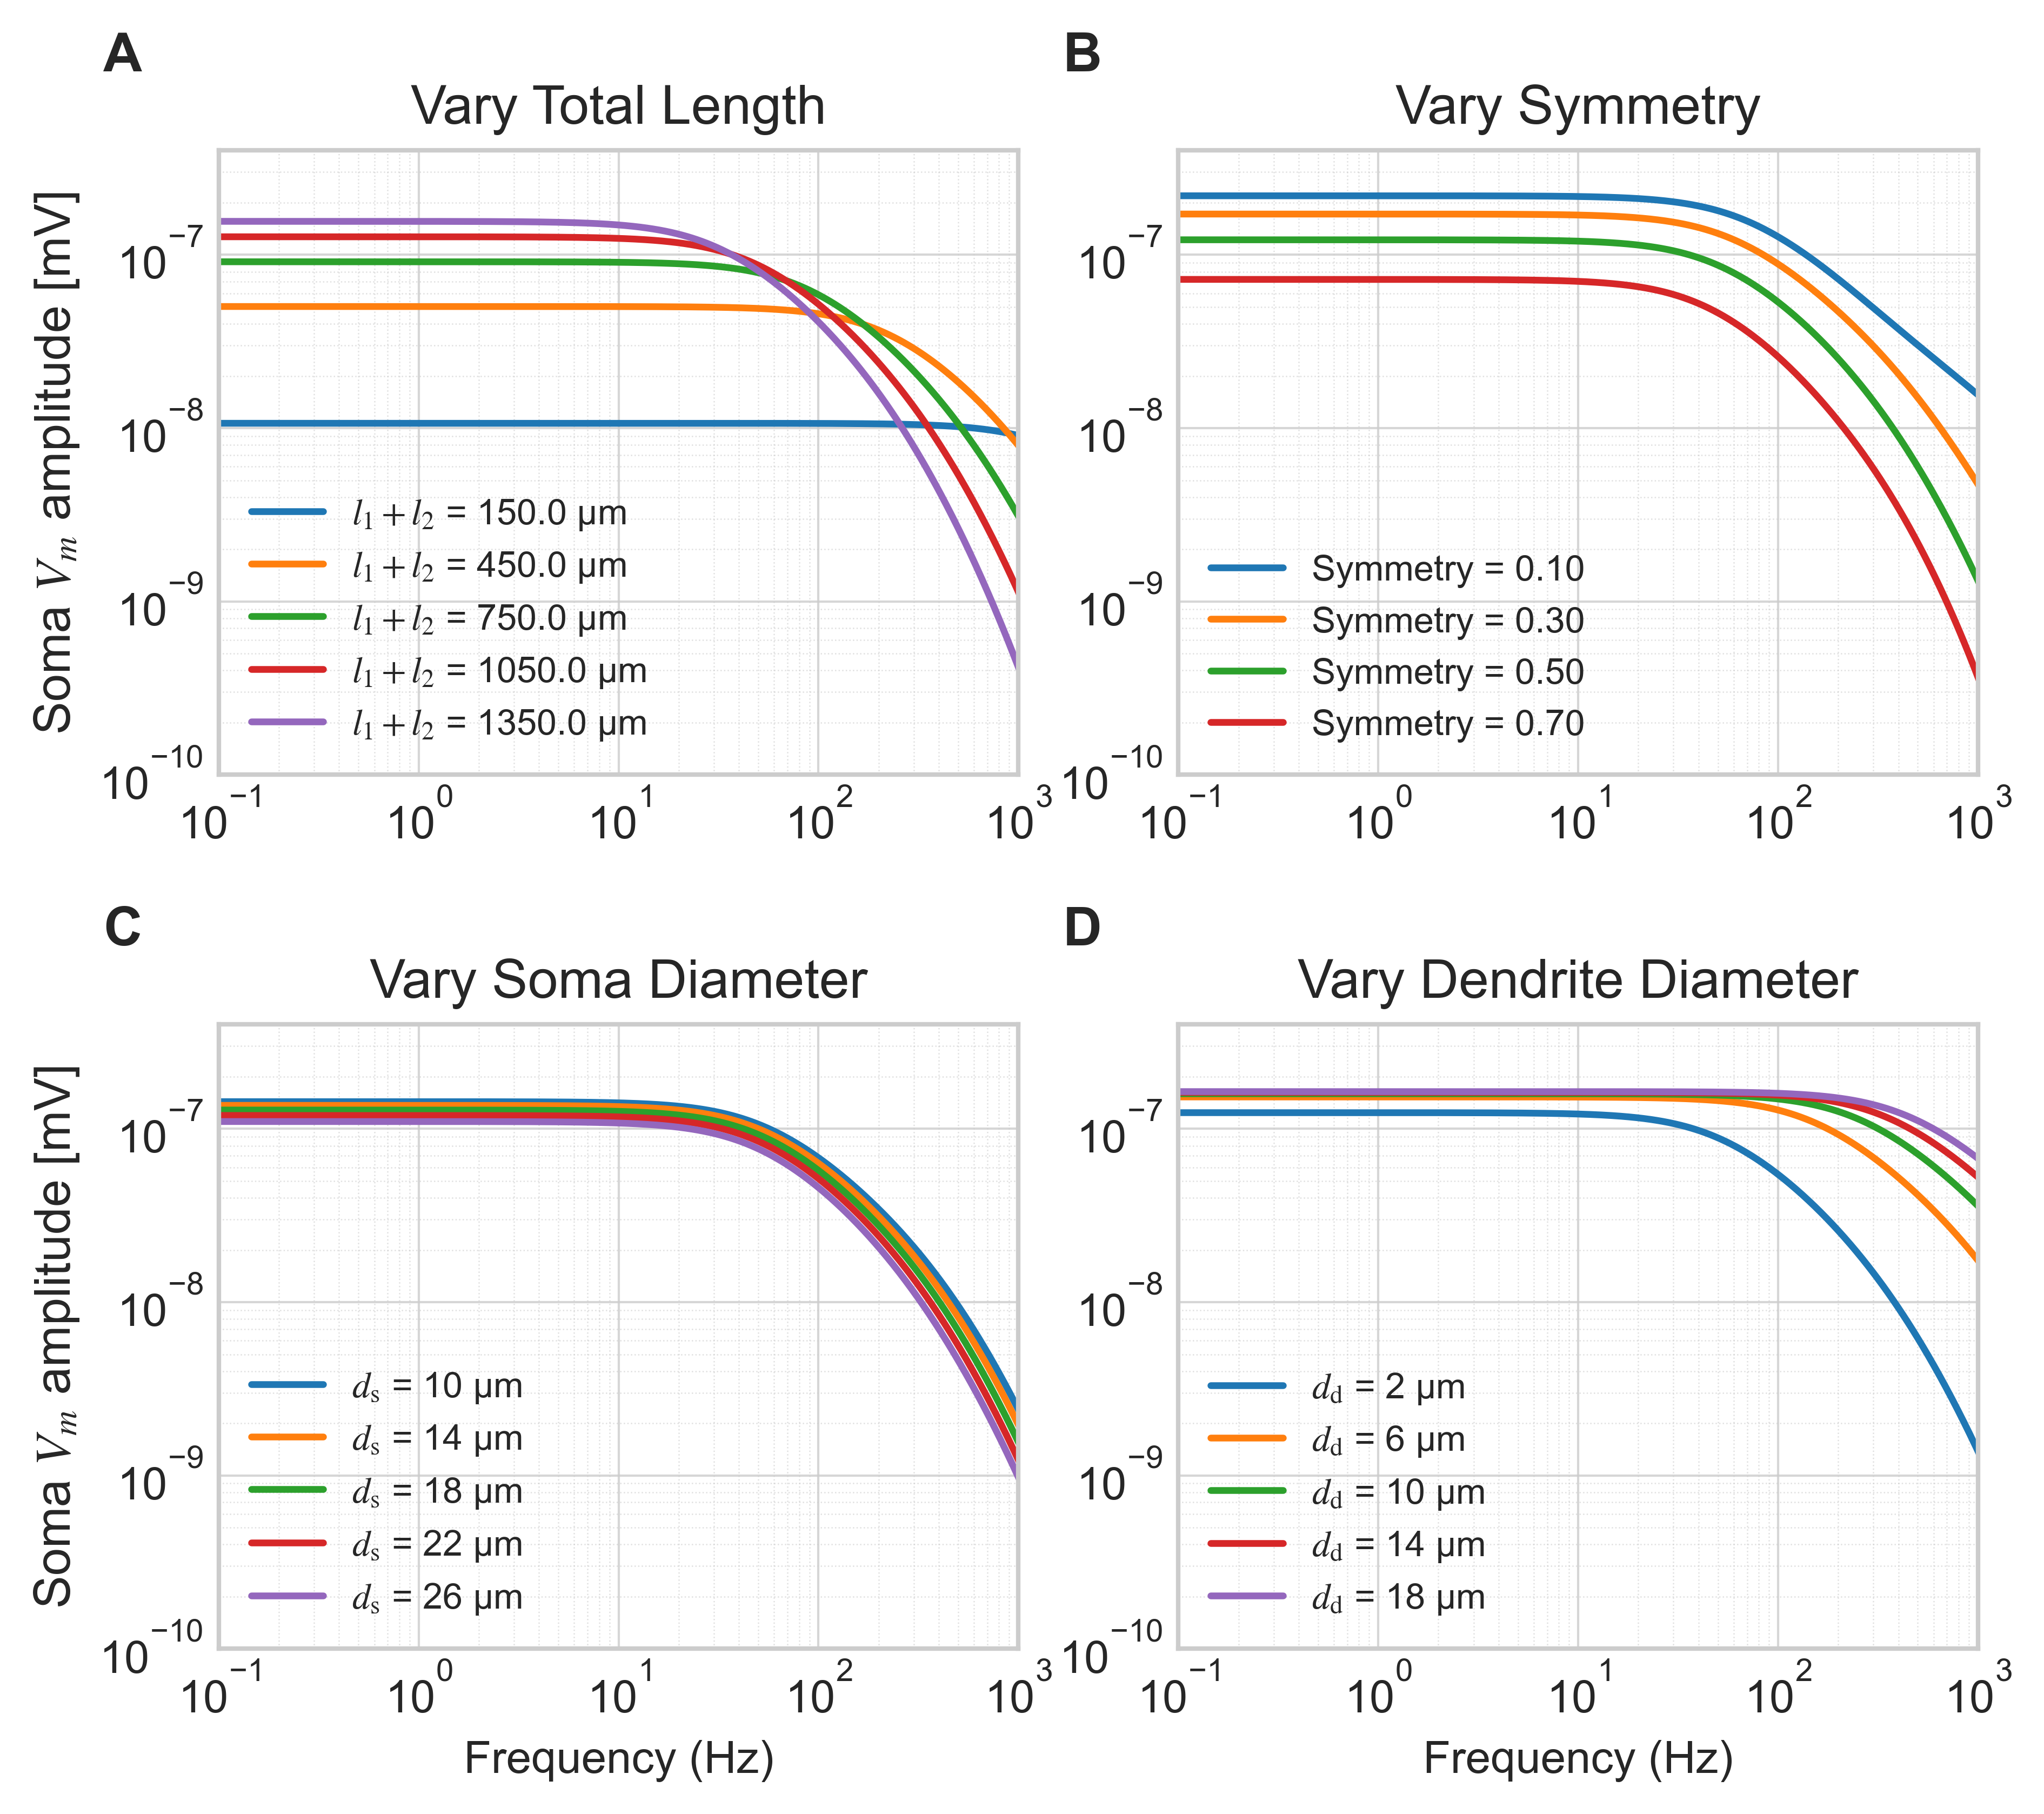

In [11]:
# --- Plotting the Results ---
plt.style.use('seaborn-v0_8-whitegrid')

# Create a figure with a specific size
fig = plt.figure(figsize=(7, 6))

plt.rcParams['font.family'] = 'sans-serif'

# Create a GridSpec layout for more control over subplot placement
# 3 rows, 2 columns
gs = gridspec.GridSpec(2, 2, figure=fig, hspace=0.4, wspace=0.2)

# Define the axes for each subplot
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])

# Common unit conversion factor
unit_conversion_factor = (1e12 * 1e3)**2
props = dict(boxstyle='round,pad=0.5', facecolor='wheat', alpha=0.5)


# --- Subplot 1: Vary total length with fixed symmetry ---
for l, data in V_m_vary_abs_len.items():
    ax1.loglog(data['freqs'], data['abs_V_m'], label=f'$l_1+l_2$ = {l} µm')
ax1.set_title('Vary Total Length')
#ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('Soma $V_m$ amplitude [mV]', fontsize = 11)
ax1.legend(fontsize = 8)
ax1.grid(which='major', linestyle='-', linewidth=0.5, alpha=0.8)
ax1.grid(which='minor', linestyle=':', linewidth=0.3, alpha=0.6)
# info_text1 = f"Fixed:\nSymmetry = {standard_neuron_parameters_sym['sym']}\n$d_{{\\mathrm{{d}}}}$ = {standard_neuron_parameters_sym['d']*1e6} µm\n$d_{{\\mathrm{{s}}}}$ = {standard_neuron_parameters_sym['ds']*1e6} µm"
# ax1.text(0.95, 0.05, info_text1, transform=ax1.transAxes, 
#          verticalalignment='bottom', horizontalalignment='right', bbox=props, fontsize = 8)
ax1.set_xlim(left=1e-1, right=1e3)
ax1.set_ylim(top = 4e-7, bottom=1e-10)

# --- Subplot 2: Vary symmetry  ---
for sym, data in V_m_vary_symmetry.items():
    ax2.loglog(data['freqs'], data['abs_V_m'], label=f'Symmetry = {sym:.2f}')
ax2.set_title('Vary Symmetry')
ax2.legend(fontsize = 8)
ax2.grid(which='major', linestyle='-', linewidth=0.5, alpha=0.8)
ax2.grid(which='minor', linestyle=':', linewidth=0.3, alpha=0.6)
ax2.set_xlim(left=1e-1, right=1e3)
ax2.set_ylim(top = 4e-7,bottom=1e-10)

# --- Subplot 3: Vary soma diameter ---
for d_s, data in V_m_vary_soma_diam.items():
    ax3.loglog(data['freqs'], data['abs_V_m'], label=f'$d_{{\\mathrm{{s}}}}$ = {d_s} µm')
ax3.set_title('Vary Soma Diameter')
ax3.set_xlabel('Frequency (Hz)')
ax3.set_ylabel('Soma $V_m$ amplitude [mV]', fontsize = 11)
ax3.legend(fontsize = 8)
ax3.grid(which='major', linestyle='-', linewidth=0.5, alpha=0.8)
ax3.grid(which='minor', linestyle=':', linewidth=0.3, alpha=0.6)
ax3.set_xlim(left=1e-1, right=1e3)
ax3.set_ylim(top = 4e-7,bottom=1e-10)

# --- Subplot 4: Vary dendrite diameter (was ax2 before) ---
for d_d, data in V_m_vary_dend_diam.items():
    ax4.loglog(data['freqs'], data['abs_V_m'], label=f'$d_{{\\mathrm{{d}}}}$ = {d_d} µm')
ax4.set_title('Vary Dendrite Diameter')
ax4.set_xlabel('Frequency (Hz)')
ax4.legend(fontsize = 8)
ax4.grid(which='major', linestyle='-', linewidth=0.5, alpha=0.8)
ax4.grid(which='minor', linestyle=':', linewidth=0.3, alpha=0.6)
ax4.set_xlim(left=1e-1, right=1e3)
ax4.set_ylim(top = 4e-7,bottom=1e-10)

# Adjust layout to prevent titles and labels from overlapping
fig.tight_layout(rect=[0, 0, 1, 0.97]) # rect is used to make space for suptitle
mark_subplots(fig.axes, fontsize=12)

plt.savefig('/Users/susannedahle/Documents/Master/Code/Plots_artikkel/transfer/T_p_vary_variables.png')
plt.show()
